In [125]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge, Lasso


RANDOM_STATE = 42
TARGET = "SalePrice"
TEST_SIZE = 0.2  # 20% of data reserved for testing

In [126]:
# Define project directories
PROJECT_ROOT = Path("..").resolve()
DATA_RAW = PROJECT_ROOT / "data" / "raw"
SPLITS_DIR = PROJECT_ROOT / "data" / "splits"
REPORTS_DIR = PROJECT_ROOT / "reports"

# Create directories if they don't exist
DATA_RAW.mkdir(parents=True, exist_ok=True)
SPLITS_DIR.mkdir(parents=True, exist_ok=True)

In [127]:
# Load dataset
df = pd.read_csv(DATA_RAW / "house_prices_train.csv")

In [128]:
# Separate features and target variable
y = df[TARGET]
X = df.drop(columns=[TARGET])

In [129]:
train_idx = np.load(SPLITS_DIR / "train_indices.npy")

X_train = X.loc[train_idx].copy()
y_train = y.loc[train_idx].copy()

In [130]:
# Identify numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.to_list()
if 'Id' in numeric_cols:
    numeric_cols.remove('Id')
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.to_list()

print(f"Categorical columns: {categorical_cols}")
print(f"Numeric columns: {numeric_cols}")

Categorical columns: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Numeric columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea'

In [131]:
# Define preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Create the pipeline with preprocessing and regression model
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", LinearRegression()),
    ]
)

In [132]:
# Fit the model
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [133]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [134]:
# Evaluate each model using cross-validation
scoring = {
    "rmse":"neg_root_mean_squared_error",
    "mae":"neg_mean_absolute_error",
}

In [135]:
alpha_results = []

alpha_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Evaluate Ridge regression for different alpha values
for alpha in alpha_values:
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("regressor", Ridge(alpha=alpha)),
        ]
    )
    
    cv_scores = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False,
    )
    
    rmse_values = -cv_scores["test_rmse"]
    mae_values = -cv_scores["test_mae"]

    ridge_result = {
        "alpha_value": alpha,
        "rmse_mean": rmse_values.mean(),
        "rmse_std": rmse_values.std(),
        "mae_mean": mae_values.mean(),
        "mae_std": mae_values.std(),
    }

    alpha_results.append(ridge_result)

# Create DataFrame and sort by RMSE mean
alpha_results_df = pd.DataFrame(alpha_results)
alpha_results_df = alpha_results_df.sort_values(by="rmse_mean")

# Display the best alpha value
ridge_best_result = alpha_results_df.iloc[0]
print(f"Best alpha: {ridge_best_result['alpha_value']}, RMSE: {ridge_best_result['rmse_mean']:.4f}")
alpha_results_df

Best alpha: 10.0, RMSE: 31556.1745


,alpha_value,rmse_mean,rmse_std,mae_mean,mae_std
4,10.000,31556.174539,7216.615113,18001.482651,581.320602
5,100.000,32304.774754,7450.226999,18382.143449,550.418938
3,1.000,32814.497631,7332.537866,18676.071378,1116.810159
2,0.100,35227.911632,7378.296507,19229.454374,964.236232
6,1000.000,35985.023798,5366.936468,20612.670160,857.574200
1,0.010,36243.910934,7490.030809,19558.037884,805.630600
0,0.001,36398.241915,7511.731520,19628.142870,785.969613


In [136]:
alpha_results_df.to_csv(REPORTS_DIR / "ridge_alpha_search.csv", index=False)


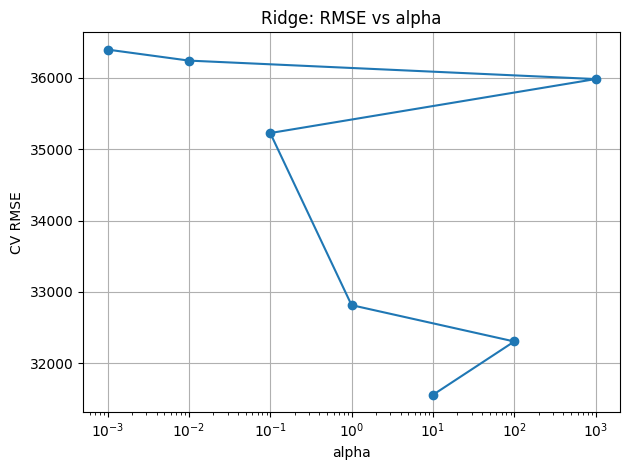

In [137]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(alpha_results_df["alpha_value"], alpha_results_df["rmse_mean"], marker="o")
plt.xscale("log")  # because alpha ranges over several orders of magnitude
plt.xlabel("alpha")
plt.ylabel("CV RMSE")
plt.title("Ridge: RMSE vs alpha")
plt.grid(True)
plt.tight_layout()
plt.savefig(REPORTS_DIR / "figures" / "ridge_alpha_curve.png")


In [138]:
lasso_results = []

alpha_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Evaluate Lasso regression for different alpha values
for alpha in alpha_values:
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            # Set max_iter=10000 to address convergence warnings in Lasso and ensure reproducibility
            ("regressor", Lasso(alpha=alpha, max_iter=10000)), 
        ]
    )
    
    cv_scores = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        return_train_score=False,
    )
    
    rmse_values = -cv_scores["test_score"]

    lasso_result = {
        "alpha_value": alpha,
        "rmse_mean": rmse_values.mean(),
        "rmse_std": rmse_values.std(),
        "mae_mean": mae_values.mean(),
        "mae_std": mae_values.std(),
    }

    lasso_results.append(lasso_result)

# Create DataFrame and sort by RMSE mean
lasso_results_df = pd.DataFrame(lasso_results)
lasso_results_df = lasso_results_df.sort_values(by="rmse_mean")

# Display the best alpha value
lasso_best_result = lasso_results_df.iloc[0]
print(f"Best alpha: {lasso_best_result['alpha_value']}, RMSE: {lasso_best_result['rmse_mean']:.4f}")
lasso_results_df

/Users/uvlazhnitel/Documents/coding/DataScience/p2-house-price/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.653e+11, tolerance: 5.386e+08
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/uvlazhnitel/Documents/coding/DataScience/p2-house-price/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.999e+10, tolerance: 5.737e+08
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/uvlazhnitel/Documents/coding/DataScience/p2-house-price/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objec

Best alpha: 100.0, RMSE: 31597.0311


,alpha_value,rmse_mean,rmse_std,mae_mean,mae_std
5,100.000,31597.031137,7633.433043,20612.67016,857.5742
6,1000.000,33640.006801,7324.297701,20612.67016,857.5742
4,10.000,34611.564554,7531.897941,20612.67016,857.5742
3,1.000,35851.981835,7413.105818,20612.67016,857.5742
2,0.100,36038.837163,7400.957267,20612.67016,857.5742
0,0.001,36087.242563,7525.866710,20612.67016,857.5742
1,0.010,36092.459471,7387.505329,20612.67016,857.5742


In [146]:
# Load baseline metrics
df_baseline = pd.read_csv(REPORTS_DIR / "metrics_baseline.csv")

# Make sure 'model' is the unique key
df_baseline = df_baseline.set_index("model")

# Prepare row names (keys)
lasso_model_name = f"Lasso (alpha={lasso_best_result['alpha_value']})"
ridge_model_name = f"Ridge (alpha={ridge_best_result['alpha_value']})"

# Update or create Lasso row
df_baseline.loc[lasso_model_name, ["rmse_mean", "rmse_std", "mae_mean", "mae_std"]] = [
    lasso_best_result["rmse_mean"],
    lasso_best_result["rmse_std"],
    lasso_best_result["mae_mean"],
    lasso_best_result["mae_std"],
]

# Update or create Ridge row
df_baseline.loc[ridge_model_name, ["rmse_mean", "rmse_std", "mae_mean", "mae_std"]] = [
    ridge_best_result["rmse_mean"],
    ridge_best_result["rmse_std"],
    ridge_best_result["mae_mean"],
    ridge_best_result["mae_std"],
]

# Reset index back to normal column and save
df_baseline = df_baseline.reset_index()  # 'model' becomes a column again
df_baseline.to_csv(REPORTS_DIR / "metrics_baseline.csv", index=False)

print(df_baseline)


                   model     rmse_mean     rmse_std      mae_mean      mae_std
0             Dummy_mean  77160.108457  3673.252798  56318.232277  2612.148500
1      Linear_Regression  36397.273713  7544.717946  19621.981805   806.121901
2        Ridge_alpha_1.0  32814.497631  7332.537866  18676.071378  1116.810159
3        Lasso_alpha_0.1  36039.211360  7401.016075  19444.763807   899.418995
4  RandomForestRegressor  30351.080615  5047.542819  18227.090934  1263.849403
5    Lasso (alpha=100.0)  31597.031137  7633.433043  20612.670160   857.574200
6     Ridge (alpha=10.0)  31556.174539  7216.615113  18001.482651   581.320602


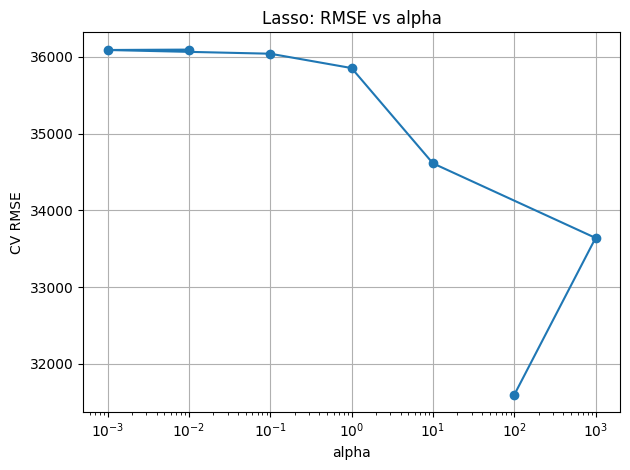

In [140]:
plt.figure()
plt.plot(lasso_results_df["alpha_value"], lasso_results_df["rmse_mean"], marker="o")
plt.xscale("log")  # because alpha ranges over several orders of magnitude
plt.xlabel("alpha")
plt.ylabel("CV RMSE")
plt.title("Lasso: RMSE vs alpha")
plt.grid(True)
plt.tight_layout()
plt.savefig(REPORTS_DIR / "figures" / "lasso_alpha_curve.png")